In [55]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, PowerTransformer, QuantileTransformer, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


### Wczytanie danych

In [56]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [57]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PatientID               15000 non-null  int64  
 1   Pregnancies             15000 non-null  int64  
 2   PlasmaGlucose           15000 non-null  int64  
 3   DiastolicBloodPressure  15000 non-null  int64  
 4   TricepsThickness        15000 non-null  int64  
 5   SerumInsulin            15000 non-null  int64  
 6   BMI                     15000 non-null  float64
 7   DiabetesPedigree        15000 non-null  float64
 8   Age                     15000 non-null  int64  
 9   Diabetic                15000 non-null  int64  
dtypes: float64(2), int64(8)
memory usage: 1.1 MB


### Procedura oceny modelu

In [58]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []
def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################
    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    # metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
    #                                              ignore_index=True)
    new_row = pd.DataFrame({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric}, index=[0])
    metrics_dataframe = pd.concat([metrics_dataframe, new_row], ignore_index=True)
    return metrics_dataframe

### Dane treningowe i testowe dla pipeline

In [59]:
features = diabetes.columns[1:9].to_list()
target = 'Diabetic'

X, y = diabetes[features], diabetes[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

### Pipeline

In [60]:
num_preparation = Pipeline(steps=[
    ('fill_missings', SimpleImputer(strategy='mean'))
])

numeric_transformer = Pipeline(steps=[
    ('standard_scaler', RobustScaler()),
    ('log_transformer', PowerTransformer()),
    ('polynomial_features', PolynomialFeatures()),
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('num_preparation', num_preparation, features),
        ('numeric_transformer', numeric_transformer, features)
        ])

pipe_line = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('regressor', LogisticRegression())
])

pipe_line.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preparation',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressure',
                                                   'TricepsThickness',
                                                   'SerumInsulin', 'BMI',
                                                   'DiabetesPedigree', 'Age']),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler()),
                                                                  ('log_transformer',
                                                                   PowerTransformer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures())]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressure',
                                                   'TricepsThickness',
                                                   'SerumInsulin', 'BMI',
                                                   'DiabetesPedigree',
                                                   'Age'])])),
                ('regressor', LogisticRegression())])

#### zmienne modelu

In [61]:
list(pipe_line.get_params().keys())

['memory',
 'steps',
 'verbose',
 'preprocessor',
 'regressor',
 'preprocessor__n_jobs',
 'preprocessor__remainder',
 'preprocessor__sparse_threshold',
 'preprocessor__transformer_weights',
 'preprocessor__transformers',
 'preprocessor__verbose',
 'preprocessor__verbose_feature_names_out',
 'preprocessor__num_preparation',
 'preprocessor__numeric_transformer',
 'preprocessor__num_preparation__memory',
 'preprocessor__num_preparation__steps',
 'preprocessor__num_preparation__verbose',
 'preprocessor__num_preparation__fill_missings',
 'preprocessor__num_preparation__fill_missings__add_indicator',
 'preprocessor__num_preparation__fill_missings__copy',
 'preprocessor__num_preparation__fill_missings__fill_value',
 'preprocessor__num_preparation__fill_missings__keep_empty_features',
 'preprocessor__num_preparation__fill_missings__missing_values',
 'preprocessor__num_preparation__fill_missings__strategy',
 'preprocessor__numeric_transformer__memory',
 'preprocessor__numeric_transformer__steps

In [62]:
pipeline_params = {'preprocessor__numeric_transformer__polynomial_features__degree': [1, 2, 3, 4],
                   'preprocessor__numeric_transformer__standard_scaler': [RobustScaler(), StandardScaler()],
                   'regressor__C': [0.1, 1.0, 10]}

In [63]:
grid_search = GridSearchCV(pipe_line, pipeline_params, cv=10, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
pipeline_optimized = grid_search.best_estimator_

pipeline_optimized.fit(X_train, y_train)

Fitting 10 folds for each of 24 candidates, totalling 240 fits
Wybrane hiperparametry:  {'preprocessor__numeric_transformer__polynomial_features__degree': 4, 'preprocessor__numeric_transformer__standard_scaler': RobustScaler(), 'regressor__C': 1.0}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_preparation',
                                                  Pipeline(steps=[('fill_missings',
                                                                   SimpleImputer())]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressure',
                                                   'TricepsThickness',
                                                   'SerumInsulin', 'BMI',
                                                   'DiabetesPedigree', 'Age']),
                                                 ('numeric_transformer',
                                                  Pipeline(steps=[('standard_scaler',
                                                                   RobustScaler()),
                                                                  ('log_transformer',
                                                                   PowerTransformer()),
                                                                  ('polynomial_features',
                                                                   PolynomialFeatures(degree=4))]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressure',
                                                   'TricepsThickness',
                                                   'SerumInsulin', 'BMI',
                                                   'DiabetesPedigree',
                                                   'Age'])])),
                ('regressor', LogisticRegression())])

### Ocena modeli

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      3000
           1       0.80      0.81      0.81      1500

    accuracy                           0.87      4500
   macro avg       0.85      0.86      0.85      4500
weighted avg       0.87      0.87      0.87      4500



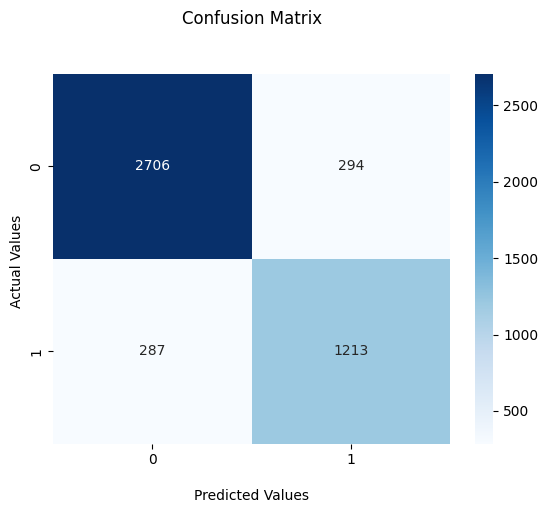

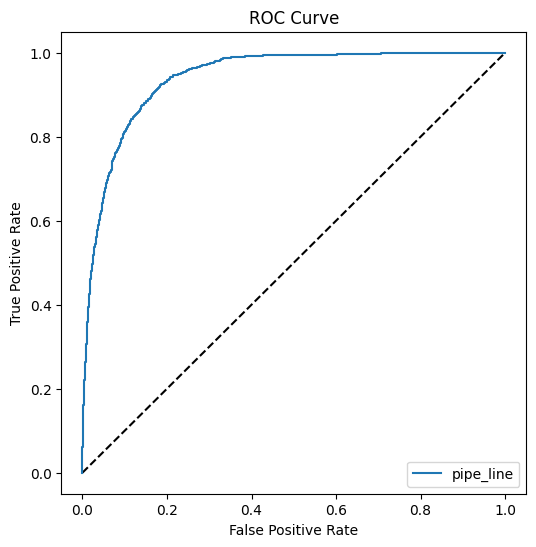

              precision    recall  f1-score   support

           0       0.91      0.91      0.91      3000
           1       0.83      0.82      0.83      1500

    accuracy                           0.88      4500
   macro avg       0.87      0.87      0.87      4500
weighted avg       0.88      0.88      0.88      4500



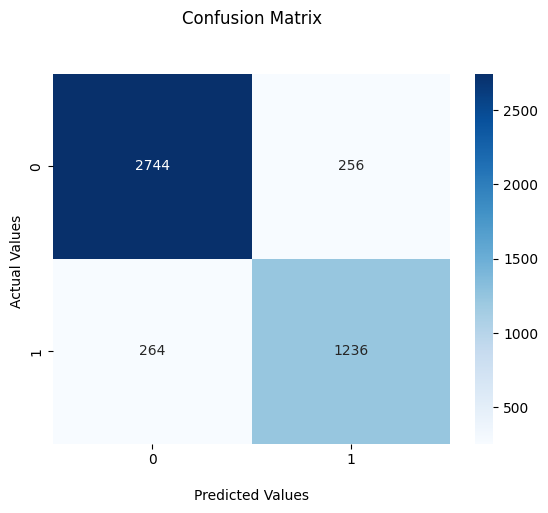

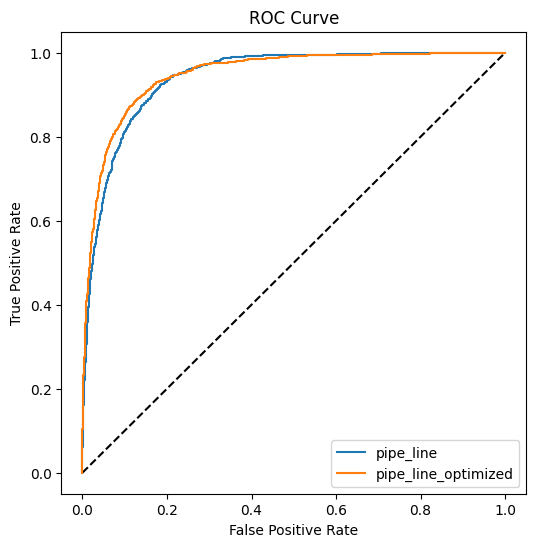

,Model,F1_score,AUC
0,pipe_line,0.806784,0.941054
1,pipe_line_optimized,0.826203,0.948105


In [64]:
calculate_metrics(pipe_line, 'pipe_line', X_test, y_test)
calculate_metrics(pipeline_optimized, 'pipe_line_optimized', X_test, y_test)